# Imports

In [1]:
from folktables import folktables
from folktables import ACSDataSource
import numpy as np
from custom_functions import *
from aif360.datasets import StandardDataset
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from aif360.metrics import ClassificationMetric
import pandas as pd
import joblib
from aif360.algorithms.preprocessing import Reweighing
import matplotlib.pyplot as plt

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


# Data Setup Code (from Spec Sheet)

In [2]:
# (Age) must be greater than 16 and less than 90,
# and (Person weight) must be greater than or equal to 1
def employment_filter(data):
    """Filters for the employment prediction task"""
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df

ACSEmployment = folktables.BasicProblem(
    features=[
        'AGEP',  # age; for range of values of features please check Appendix B.4 of Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
        'SCHL',  # educational attainment
        'MAR',   # marital status
        'RELP',  # relationship
        'DIS',   # disability recode
        'ESP',   # employment status of parents
        'CIT',   # citizenship status
        'MIG',   # mobility status (lived here 1 year ago)
        'MIL',   # military service
        'ANC',   # ancestry recode
        'NATIVITY',  # nativity
        'DEAR',   # hearing difficulty
        'DEYE',   # vision difficulty
        'DREM',   # cognitive difficulty
        'SEX',    # sex
        'RAC1P',  # recoded detailed race code
        'GCL',    # grandparents living with grandchildren
    ],
    target='ESR',  # employment status recode
    target_transform=lambda x: x == 1,
    group='DIS',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True)  # data for Florida state

features, label, group = ACSEmployment.df_to_numpy(acs_data)

data = pd.DataFrame(features, columns=ACSEmployment.features)
data['label'] = label

favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])

data_for_aif = StandardDataset(
    data,
    label_name='label',
    favorable_classes=favorable_classes,
    protected_attribute_names=protected_attribute_names,
    privileged_classes=privileged_classes
)

privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]

/Users/kyhi2018/Desktop/Imperial/Ethics, Fairness, and Explainability in AI/CW1 - Fairness/Fairness-in-AI/venv/lib/python3.11/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


# Task 1

In [3]:
# Split the dataset into train-val and test sets
train_and_val_data_2, test_data_1 = data_for_aif.split([0.7], shuffle=True, seed=0)

# Apply grid search and randomised train-val splits, saving all results and exporting best models
cc_style = 'weighted_with_penalty'
task_1_results = grid_search_models(train_and_val_data_2, custom_criterion_style=cc_style)

reweight = False
Training model with C = 1e-06 and solver = newton-cg


/Users/kyhi2018/Desktop/Imperial/Ethics, Fairness, and Explainability in AI/CW1 - Fairness/Fairness-in-AI/custom_functions.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)


Training model with C = 1e-06 and solver = lbfgs
Training model with C = 1e-06 and solver = liblinear
Training model with C = 1e-06 and solver = sag
Training model with C = 1e-06 and solver = saga
Training model with C = 1e-05 and solver = newton-cg
Training model with C = 1e-05 and solver = lbfgs
Training model with C = 1e-05 and solver = liblinear
Training model with C = 1e-05 and solver = sag
Training model with C = 1e-05 and solver = saga
Training model with C = 0.0001 and solver = newton-cg
Training model with C = 0.0001 and solver = lbfgs
Training model with C = 0.0001 and solver = liblinear
Training model with C = 0.0001 and solver = sag
Training model with C = 0.0001 and solver = saga
Training model with C = 0.001 and solver = newton-cg
Training model with C = 0.001 and solver = lbfgs
Training model with C = 0.001 and solver = liblinear
Training model with C = 0.001 and solver = sag
Training model with C = 0.001 and solver = saga
Training model with C = 0.01 and solver = newton

### Training and Validation Results

Best accuracy:
        C Solver  Mean accuracy  Mean EOD  Mean custom criterion
21  0.01  lbfgs       0.751253  0.615774               0.519705 

Best EOD:
           C     Solver  Mean accuracy  Mean EOD  Mean custom criterion
0  0.000001  newton-cg       0.542484  0.019263               0.627452
1  0.000001      lbfgs       0.542262  0.019263               0.626786
4  0.000001       saga       0.542390  0.019263               0.627170 

Lowest non-zero EOD:
           C     Solver  Mean accuracy  Mean EOD  Mean custom criterion
0  0.000001  newton-cg       0.542484  0.019263               0.627452
1  0.000001      lbfgs       0.542262  0.019263               0.626786
4  0.000001       saga       0.542390  0.019263               0.627170 

Best criterion (weighted_with_penalty):
           C Solver  Mean accuracy  Mean EOD  Mean custom criterion
3  0.000001    sag       0.542894  0.020327               0.628681 



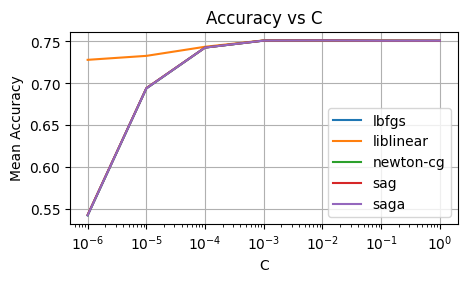

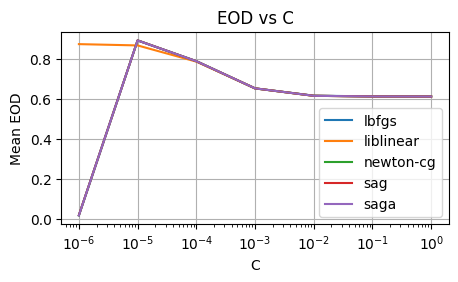

In [4]:
# Find the best model
best_accuracy_1, best_eod_1, best_nonzero_eod_1, best_cc_1 = find_best_results(task_1_results)

# Print results
print(f"Best accuracy:\n", best_accuracy_1, f'\n')
print(f"Best EOD:\n", best_eod_1, f'\n')
print(f"Lowest non-zero EOD:\n", best_nonzero_eod_1, f'\n')
print(f"Best criterion ({cc_style}):\n", best_cc_1, f'\n')

# Plot results
plot_results(task_1_results, 'accuracy', 'Accuracy vs C','Task_1_accuracy.png')
plot_results(task_1_results, 'eod', 'EOD vs C','Task_1_eod.png')

### Performance on Held-out Test Set

In [5]:
# Metrics for both the best accuracy and best EOD models
best_accuracy_accuracy_1, best_accuracy_eod_1, best_accuracy_cc_1 = test_model(test_data_1, 'std_model_accuracy.joblib', cc_style)
best_eod_accuracy_1, best_eod_eod_1, best_eod_cc_1 = test_model(test_data_1, 'std_model_eod.joblib', cc_style)
best_cc_accuracy_1, best_cc_eod_1, best_cc_cc_1 = test_model(test_data_1, 'std_model_cc.joblib', cc_style)

# Print results
print("Most accurate model:")
print(f"Accuracy: {best_accuracy_accuracy_1}")
print(f"EOD: {best_accuracy_eod_1}")
print(f"Custom criterion: {best_accuracy_cc_1}", f'\n')

print("Best EOD model:")
print(f"Accuracy: {best_eod_accuracy_1}")
print(f"EOD: {best_eod_eod_1}")
print(f"Custom criterion: {best_eod_cc_1}", f'\n')

print("Best CC model:")
print(f"Accuracy: {best_cc_accuracy_1}")
print(f"EOD: {best_cc_eod_1}")
print(f"Custom criterion: {best_cc_cc_1}")

Most accurate model:
Accuracy: 0.7523310487727127
EOD: 0.6736529561484942
Custom criterion: 0.40502513647572436 

Best EOD model:
Accuracy: 0.541819413452343
EOD: 0.01934235976789167
Custom criterion: 0.6254582403570289 

Best CC model:
Accuracy: 0.5452861013707364
EOD: 0.023855577047066423
Custom criterion: 0.6358583041122093


# Task 2

In [6]:
# Split the dataset into train-val and test sets
train_and_val_data_2, test_data_2 = data_for_aif.split([0.7], shuffle=True, seed=0)

# Apply grid search and randomised train-val splits, saving all results and exporting best models
task_2_results = grid_search_models(train_and_val_data_2, reweight=True, custom_criterion_style=cc_style)

reweight = True
Training model with C = 1e-06 and solver = newton-cg


/Users/kyhi2018/Desktop/Imperial/Ethics, Fairness, and Explainability in AI/CW1 - Fairness/Fairness-in-AI/custom_functions.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)


Training model with C = 1e-06 and solver = lbfgs
Training model with C = 1e-06 and solver = liblinear
Training model with C = 1e-06 and solver = sag
Training model with C = 1e-06 and solver = saga
Training model with C = 1e-05 and solver = newton-cg
Training model with C = 1e-05 and solver = lbfgs
Training model with C = 1e-05 and solver = liblinear
Training model with C = 1e-05 and solver = sag
Training model with C = 1e-05 and solver = saga
Training model with C = 0.0001 and solver = newton-cg
Training model with C = 0.0001 and solver = lbfgs
Training model with C = 0.0001 and solver = liblinear
Training model with C = 0.0001 and solver = sag
Training model with C = 0.0001 and solver = saga
Training model with C = 0.001 and solver = newton-cg
Training model with C = 0.001 and solver = lbfgs
Training model with C = 0.001 and solver = liblinear
Training model with C = 0.001 and solver = sag
Training model with C = 0.001 and solver = saga
Training model with C = 0.01 and solver = newton

### Training and Validation Results

Best accuracy:
         C     Solver  Mean accuracy  Mean EOD  Mean custom criterion
15  0.001  newton-cg        0.72007 -0.018474                1.16021
19  0.001       saga        0.72007 -0.018457                1.16021 

Best EOD:
           C     Solver  Mean accuracy  Mean EOD  Mean custom criterion
0  0.000001  newton-cg       0.526081       0.0               0.578244
1  0.000001      lbfgs       0.526081       0.0               0.578244
3  0.000001        sag       0.526081       0.0               0.578244
4  0.000001       saga       0.526081       0.0               0.578244 

Lowest non-zero EOD:
         C Solver  Mean accuracy  Mean EOD  Mean custom criterion
18  0.001    sag       0.720036 -0.018224               1.160108 

Best criterion (weighted_with_penalty):
         C     Solver  Mean accuracy  Mean EOD  Mean custom criterion
15  0.001  newton-cg        0.72007 -0.018474                1.16021
19  0.001       saga        0.72007 -0.018457                1.16021 



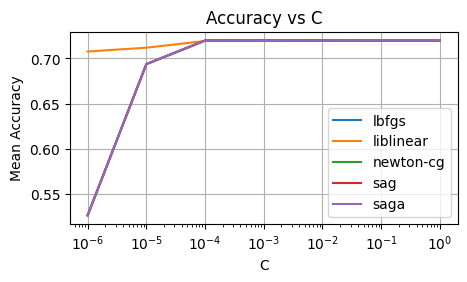

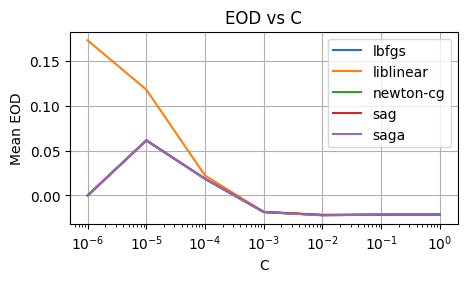

           C     Solver  Mean accuracy  Mean EOD  Mean custom criterion
0   0.000001  newton-cg       0.526081  0.000000               0.578244
1   0.000001      lbfgs       0.526081  0.000000               0.578244
2   0.000001  liblinear       0.707723  0.172842               1.123170
3   0.000001        sag       0.526081  0.000000               0.578244
4   0.000001       saga       0.526081  0.000000               0.578244
5   0.000010  newton-cg       0.693780  0.061442               1.081339
6   0.000010      lbfgs       0.693763  0.061425               1.081288
7   0.000010  liblinear       0.711950  0.117907               1.135849
8   0.000010        sag       0.693711  0.061476               1.081134
9   0.000010       saga       0.693728  0.061476               1.081185
10  0.000100  newton-cg       0.719959  0.018623               1.159877
11  0.000100      lbfgs       0.719857  0.018589               1.159570
12  0.000100  liblinear       0.719370  0.022260               1

In [7]:
# Find the best results
best_accuracy_2, best_eod_2, best_nonzero_eod_2, best_cc_2 = find_best_results(task_2_results)

# Print results analysis
print(f"Best accuracy:\n", best_accuracy_2, f'\n')
print(f"Best EOD:\n", best_eod_2, f'\n')
print(f"Lowest non-zero EOD:\n", best_nonzero_eod_2, f'\n')
print(f"Best criterion ({cc_style}):\n", best_cc_2, f'\n')

# Plot results
plot_results(task_2_results, 'accuracy', 'Accuracy vs C','Task_2_accuracy.png')
plot_results(task_2_results, 'eod', 'EOD vs C','Task_2_eod.png')

print(task_2_results)

### Performance on Held-out Test Set

In [8]:
# Metrics for both the best accuracy and best EOD models
best_accuracy_accuracy_2, best_accuracy_eod_2, best_accuracy_cc_2 = test_model(test_data_2, 'fair_model_accuracy.joblib', cc_style)
best_eod_accuracy_2, best_eod_eod_2, best_eod_cc_2 = test_model(test_data_2, 'fair_model_eod.joblib', cc_style)
best_cc_accuracy_2, best_cc_eod_2, best_cc_cc_2 = test_model(test_data_2, 'fair_model_cc.joblib', cc_style)

# Print results
print("Most accurate model:")
print(f"Accuracy: {best_accuracy_accuracy_2}")
print(f"EOD: {best_accuracy_eod_2}", f'\n')
print(f"Custom criterion: {best_accuracy_cc_2}")

print("Best EOD model:")
print(f"Accuracy: {best_eod_accuracy_2}")
print(f"EOD: {best_eod_eod_2}")
print(f"Custom criterion: {best_eod_cc_2}")

print("Best CC model:")
print(f"Accuracy: {best_cc_accuracy_2}")
print(f"EOD: {best_cc_eod_2}", f'\n')
print(f"Custom criterion: {best_cc_cc_2}")


Most accurate model:
Accuracy: 0.7197760599298693
EOD: 0.004663503874752228 

Custom criterion: 1.1593281797896078
Best EOD model:
Accuracy: 0.525880618425247
EOD: 0.0
Custom criterion: 0.5776418552757411
Best CC model:
Accuracy: 0.7197760599298693
EOD: 0.004663503874752228 

Custom criterion: 1.1593281797896078


# Task 3